In [30]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

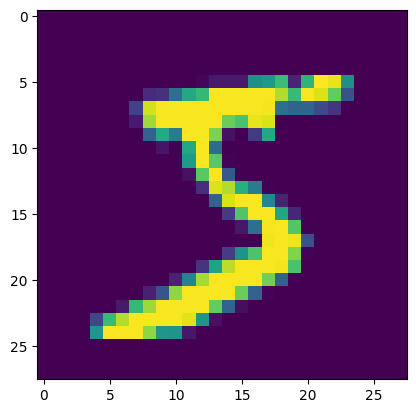

In [31]:
(train_images,train_labels),(test_images,test_labels) = tf.keras.datasets.mnist.load_data()
plt.imshow(train_images[0])

In [32]:
train_images.shape

(60000, 28, 28)

In [33]:

(train_images,train_labels),(test_images,test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

In [13]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [34]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]


In [35]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

#train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)


In [20]:
train_dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)>

In [36]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model

In [37]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
  
    return model

In [38]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [39]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

def generator_loss(generated_output):
    return tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(generated_output), logits = generated_output)  # one cause Gen try to reach one - output of the Dis on fake data 

In [40]:
generator_optimizer = tf.optimizers.Adam(1e-4)  # exponent 0.0001
discriminator_optimizer = tf.optimizers.Adam(1e-4)

In [41]:
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])

In [42]:
random_vector_for_generation

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[ 2.012171  , -1.5859101 , -0.45920548, ..., -0.4955134 ,
         0.6478364 ,  1.352662  ],
       [-1.2729261 ,  1.9038891 ,  1.0553296 , ...,  1.8677328 ,
         0.55617166,  1.1249131 ],
       [-0.6564564 , -1.5052791 , -1.4250046 , ...,  0.41522834,
         1.2077405 ,  0.33479267],
       ...,
       [-0.9611521 ,  0.9374268 , -0.6605848 , ..., -0.46404773,
         0.20682627,  0.87998265],
       [ 0.27870888, -1.1461867 ,  1.7571371 , ...,  1.1490295 ,
         0.2182618 ,  0.5636324 ],
       [-0.02516993,  0.5012503 , -1.1131209 , ...,  0.6812573 ,
        -0.6325575 ,  0.49788   ]], dtype=float32)>

In [43]:
EPOCHS = 50

def train_step(images):
   # generating noise from a normal distribution
    fake_img_noise = tf.random.normal([BATCH_SIZE, noise_dim]).astype("float32")
      
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = make_generator_model(fake_img_noise)
        real_output = make_discriminator_model(images)
        generated_output = make_discriminator_model(generated_images)

        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, make_generator_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, make_generator_model.trainable_variables))
        
    gradients_of_discriminator = disc_tape.gradient(disc_loss, make_discriminator_model.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, make_discriminator_model.trainable_variables))

def train(dataset, epochs):  
    for epoch in range(epochs):
      for images in dataset:
        images = tf.cast(images , tf.dtypes.float32)
        train_step(images)    

In [44]:
train(train_dataset, EPOCHS)


TypeError: ignored

In [73]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define hyperparameters
EPOCHS = 50
BATCH_SIZE = 128
noise_dim = 100
num_examples_to_generate = 16

# Load the MNIST dataset
(x_train, _), (_, _) = keras.datasets.mnist.load_data()
#train_dataset, validation_dataset, test_dataset = keras.datasets.celeba.load_data()


# Normalize the pixel values to be between -1 and 1
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5

# Create a tf.data.Dataset object for the MNIST dataset
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)


# Create the generator and discriminator models
def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss functions for the generator and discriminator
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define the optimizers for the generator and discriminator
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

# Define the training loop
def train_step(images):
    # Generating noise from a normal distribution
    fake_img_noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(fake_img_noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        print("gen_loss" , np.mean(gen_loss))
        print("disc_loss" , np.mean(disc_loss))
        #print("gen_loss" , gen_loss)

# Train the GAN model
def train(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            train_step(batch)

# Train the GAN model
train(dataset, EPOCHS)

Streaming output truncated to the last 5000 lines.
gen_loss tf.Tensor(0.99018776, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2138152, shape=(), dtype=float32)
gen_loss tf.Tensor(0.914184, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2356714, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9052839, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3208325, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9575879, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2260399, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9356175, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2592847, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9668725, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2156724, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90690404, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2628043, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86610234, shape=(), dtype=float32)
disc_loss tf.Tensor(1.295829, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8703257, shape=(), dtype=float32)
disc_

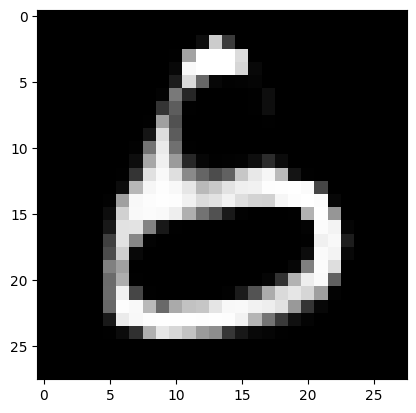

In [95]:
plt.imshow(generator(np.random.randn(1,100)).reshape(28,28),cmap='gray')


In [72]:
a = np.random.randn(2,100)
a.shape

(2, 100)

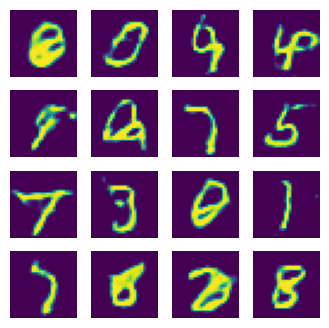

In [96]:
# Save the generator weights to a file
generator.save_weights('generator_weights.h5')

# Load the generator weights from the file
generator.load_weights('generator_weights.h5')

# Generate some fake images using the trained generator
noise = tf.random.normal([num_examples_to_generate, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4,4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((generated_images[i]*0.5 + 0.5).numpy())
    plt.axis('off')
plt.show()